### Блок кода для парсинга

In [1]:
pip install --upgrade undetected-chromedriver

In [1]:
pip install tenacity

Note: you may need to restart the kernel to use updated packages.


In [20]:
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait     # позволяет устанавливать таймауты для ожидания в случае, если элементы на странице загружаются асинхронно
from selenium.webdriver.support import expected_conditions as EC        # набор встроенных условий для используемых ожиданий (наличие/видимость элемента и т.д.)
from selenium.common.exceptions import TimeoutException     # исключение, когда заданный временной предел ожидания истекат и требуемый элемент не найден на странице. Помогает обрабатывать ошибки при отсутствии загрузки элементов
from selenium.webdriver.common.action_chains import ActionChains        # для выполнения сложных пользовательских действий
import os       # стандарт для работы с операционной системой (работа с файлами, получение переменных окружения, управление процессами)
import time
import glob     # функция для поиска файлов в файловой системе с использованием шаблонов
from tenacity import retry, stop_after_attempt, wait_fixed      # tenacity - библиотека для повторных попыток выполнения фнк в случае неудачи; retry - повторно вызывает фнк; 
#stop_after_attempt - задает максимально количество попыток, # wait_fixed - позволяет устанавливать фиксированную задержку между попытками

# Настройка параметров загрузки
download_dir = r"C:\Users\Катерина Андреевна\code\парсинг\pdf + supplementary information"
if not os.path.exists(download_dir):        # проверяет, существует ли заданная директория
    os.makedirs(download_dir)       # иначе создается папка, указанная в переменной
    print(f"Создана папка: {download_dir}")

# Конфигурация ChromeOptions
options = uc.ChromeOptions()        # задает различные настройки и параметры для браузера Google Chrome
prefs = {                           # создает словарь, где задаются предпочтения для конфигурации поведения загрузок
    "download.default_directory": download_dir,     # установка директории по умолчанию 
    "download.prompt_for_download": False,      # делает загрузку автоматизированной (отключает запрос на подтверждение загрузки файлов)
    "download.directory_upgrade": True,     # позволяет обновлять существующую папку для загрузки файлов
    "plugins.always_open_pdf_externally": True,     # позволяет открывать pdf-файлы в сторонних приложениях, а не в браузере (хз насколько нужна в моем случае)
    "profile.default_content_settings.popups": 0,       # отключает всплывающие окна, чтобы не мешали автоматизации
    "profile.content_settings.exceptions.automatic_downloads.*.setting": 1      # разрешает автоматическую загрузку файлов, убирая ограничения на автоматизацию (может и тоже не нужна?...)
}
options.add_experimental_option("prefs", prefs)     # заданный выше словарь добавляет к объекту options
options.add_argument("--disable-blink-features=AutomationControlled")       # отключает некоторые функции, которые могут указывать на то, что браузер управляется автоматически
options.add_argument("--disable-extensions")        # отключает расширения в браузере для усорения его загрузки 
options.add_argument("--no-sandbox")        # "песочница" изолирует процессы браузера от системы 
options.add_argument("--disable-popup-blocking")        # блокирует всплывающие окна

# Инициализация драйвера
driver = uc.Chrome(options=options)     # экземпляр браузера
wait = WebDriverWait(driver, 60)        # 60 - макс. количество секунд,в течение которого драйвер будет ждать опр-х элементов на странице

# Функция для ожидания полной загрузки страницы
def wait_for_page_load(driver, timeout=60):
    try:
        WebDriverWait(driver, timeout).until(
            lambda d: d.execute_script('return document.readyState') == 'complete'      # проверяет состояние загрузки элемента
        )
        print("Страница полностью загружена")
    except TimeoutException:
        print("Таймаут ожидания загрузки страницы")
        raise

# Функция для ожидания загрузки файла
def wait_for_download(download_dir, timeout=180, expected_file=None):
    print("Ожидание загрузки файла...")
    initial_files = set(glob.glob(os.path.join(download_dir, "*.pdf")) + glob.glob(os.path.join(download_dir, "*.zip")))
    start_time = time.time()    # запоминает время начала ожидания, возвращает текущее время в секундах
    while time.time() - start_time < timeout:       # продолжается до тех пор, пока затраченное время не превысит установленный таймаунт 
        current_files = set(glob.glob(os.path.join(download_dir, "*.pdf")) + glob.glob(os.path.join(download_dir, "*.zip")))        # отражает текущее состояние загруженных файлов в той же директории
        new_files = current_files - initial_files       # вычисляет новые файлы, которые появились в директории с момента последнего обновления
        if new_files:       # если есть новые файлы, то загрузка завершилась
            downloaded_file = new_files.pop()       
            print(f"Файл загружен: {downloaded_file}")
            if expected_file and expected_file not in downloaded_file:
                print(f"Предупреждение: Загружен файл {downloaded_file}, а ожидался {expected_file}")
            return True
        time.sleep(1)
    return False

# Функция для получения элемента из Shadow DOM
def get_shadow_root_element(driver, selector):
    return driver.execute_script(f"return document.querySelector('{selector}').shadowRoot")

# Открываем страницу
try:
    print("Открываем страницу статьи")
    driver.get('https://doi.org/10.1080/10495398.2025.2547345')
    wait_for_page_load(driver)

    # Шаг 1: Опциональная обработка окна Privacy Choices
    try:        # через try мы отлавливаем ошибки - т.е. это блок кода, где могут возникнуть ошибки
        print("Проверка наличия окна Privacy Choices (Transcend)...")
        short_wait = WebDriverWait(driver, 5)     # блок для ожидания появления элементов
        modal_container = short_wait.until(     # контейнер модального окна выбора условий конфиденциальности
            EC.presence_of_element_located((By.ID, 'transcend-consent-manager-tcf-ui'))
        )
        print("Контейнер модального окна найден")       # модальное окно - элемент, растянутый по шиирине и высоте документа в бразуер поверх приложения 

        shadow_root = get_shadow_root_element(driver, '#transcend-consent-manager-tcf-ui')      # проверка: использует ли модальное окно Shadow DOM для изоляции содержимого
        if shadow_root:
            print("Shadow Root найден, ищем кнопку внутри")
            accept_button = wait.until(     # сценарий поиска кнопки
                EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'button-primary') and .//span[contains(text(), 'Accept All')]]"))
            )
        else:
            print("Shadow Root не найден, ищем кнопку в основном DOM")
            accept_button = wait.until(
                EC.element_to_be_clickable((By.XPATH, "//div[@id='transcend-consent-manager-tcf-ui']//div[contains(@class, 'submission-container')]//button[contains(@class, 'button-primary') and .//span[contains(text(), 'Accept All')]]"))
            )

        print("Кнопка Accept All найдена")
        driver.execute_script("arguments[0].click();", accept_button)       # клик по кнопке 
        wait.until(EC.invisibility_of_element_located((By.ID, 'transcend-consent-manager-tcf-ui')))
        print("Окно Privacy Choices закрыто")
    except TimeoutException:
        print("Окно Privacy Choices не появилось — продолжаем без него")
    except Exception as e:
        print(f"Ошибка при обработке Privacy Choices: {str(e)}")
        with open("page_source.html", "w", encoding="utf-8") as f:
            f.write(driver.page_source)
        driver.save_screenshot("privacy_window_error.png")
        print("Проверьте page_source.html и privacy_window_error.png")
        raise Exception("Не удалось закрыть Privacy Choices")

    # Шаг 2: Ищем кнопку View PDF
    @retry(stop=stop_after_attempt(3), wait=wait_fixed(2))
    def find_and_click_pdf_button():
        try:
            print("Поиск кнопки View PDF...")
            pdf_button = wait.until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, 'a.show-pdf'))
            )
        except:
            print("Кнопка с CSS 'a.show-pdf' не найдена, пробуем XPath")
            pdf_button = wait.until(
                EC.element_to_be_clickable((By.XPATH, '//a[contains(@href, "/doi/epdf/")]'))
            )

        print("Кнопка PDF найдена, скроллим к элементу")
        driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", pdf_button)
        time.sleep(1)

        print("Нажатие кнопки PDF")
        try:
            pdf_button.click()
        except:
            print("Обычный клик не сработал, пробуем через JavaScript")
            driver.execute_script("arguments[0].click();", pdf_button)
        print("Кнопка ePDF нажата")

    find_and_click_pdf_button()

    # Шаг 3: Проверка открытия новой вкладки и скачивание PDF
    time.sleep(3)
    print(f"Количество открытых вкладок: {len(driver.window_handles)}")

    if len(driver.window_handles) > 1:
        driver.switch_to.window(driver.window_handles[1])
        print("Переключились на новую вкладку")
        wait_for_page_load(driver)

        # Шаг 4: Ищем и нажимаем кнопку скачивания PDF через выпадающее меню
        @retry(stop=stop_after_attempt(3), wait=wait_fixed(2))
        def find_and_click_download_button():
            print("Поиск кнопки скачивания в выпадающем меню...")
            download_button = wait.until(
                EC.element_to_be_clickable((By.ID, 'new-download-btn'))
            )
            driver.execute_script("arguments[0].click();", download_button)
            print("Выпадающее меню открыто")

            pdf_link = wait.until(
                EC.element_to_be_clickable((By.XPATH, "//a[@data-download-files-key='pdf']"))
            )
            print("Кнопка PDF найдена в меню")
            driver.execute_script("arguments[0].click();", pdf_link)
            print("Кнопка PDF в меню нажата")

        find_and_click_download_button()
    else:
        print("Новая вкладка не открылась, пробуем найти кнопку в текущей вкладке")
        @retry(stop=stop_after_attempt(3), wait=wait_fixed(2))
        def find_and_click_download_button_current():
            print("Поиск кнопки скачивания в текущей вкладке...")
            try:
                download_button = wait.until(
                    EC.element_to_be_clickable((By.ID, 'new-download-btn'))
                )
                driver.execute_script("arguments[0].click();", download_button)
                print("Выпадающее меню открыто в текущей вкладке")
            except:
                print("Кнопка 'new-download-btn' не найдена, ищем напрямую PDF")

            pdf_link = wait.until(
                EC.element_to_be_clickable((By.XPATH, "//a[@data-download-files-key='pdf']"))
            )
            print("Кнопка PDF найдена в текущей вкладке")
            driver.execute_script("arguments[0].click();", pdf_link)
            print("Кнопка PDF нажата")

        find_and_click_download_button_current()

    # Шаг 5: Ожидание загрузки основного PDF
    if wait_for_download(download_dir):
        print("Файл PDF успешно загружен")
    else:
        print("Не удалось загрузить основной PDF")
        with open("download_error_page_source.html", "w", encoding="utf-8") as f:
            f.write(driver.page_source)
        driver.save_screenshot("download_error.png")
        raise Exception("Загрузка основного PDF не удалась")

    # Шаг 6: Закрытие вкладки с PDF и возвращение к основной
    if len(driver.window_handles) > 1:
        driver.close()  # Закрываем вкладку с PDF
        print("Вкладка с PDF закрыта")
        driver.switch_to.window(driver.window_handles[0])  # Возвращаемся к основной вкладке
        print("Переключились на основную вкладку")
        wait_for_page_load(driver)
    else:
        print("Только одна вкладка, остаемся на текущей")

    # Шаг 7: Скачивание Supplementary Information
    @retry(stop=stop_after_attempt(3), wait=wait_fixed(2))
    def find_and_click_suppl_button():
        print("Поиск кнопки Supplementary Information...")
        suppl_button = wait.until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'a#showSuppl.show-supplement'))
        )
        print("Кнопка Supplementary найдена, скроллим к элементу")
        driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", suppl_button)
        time.sleep(1)
        print("Нажатие кнопки Supplementary")
        driver.execute_script("arguments[0].click();", suppl_button)
        print("Кнопка Supplementary нажата")

    find_and_click_suppl_button()

    # Ожидание загрузки страницы с дополнительными материалами
    wait_for_page_load(driver)

    # Шаг 8: Поиск и нажатие кнопки Download для Supplementary
    @retry(stop=stop_after_attempt(3), wait=wait_fixed(2))
    def find_and_click_suppl_download_button():
        print("Поиск кнопки Download для Supplementary...")
        download_button = wait.until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'a.frontend-filesViewer-inlineMode-downloadMenu-trigger-module__downloadButton--UsBvq'))
        )
        print("Кнопка Download для Supplementary найдена")
        driver.execute_script("arguments[0].click();", download_button)
        print("Кнопка Download для Supplementary нажата")

    find_and_click_suppl_download_button()

    # Шаг 9: Ожидание загрузки Supplementary файла
    if wait_for_download(download_dir, expected_file="57362665"):  # Часть имени файла из URL
        print("Файл Supplementary успешно загружен")
    else:
        print("Не удалось загрузить Supplementary")
        with open("suppl_download_error_page_source.html", "w", encoding="utf-8") as f:
            f.write(driver.page_source)
        driver.save_screenshot("suppl_download_error.png")
        raise Exception("Загрузка Supplementary не удалась")

finally:
    driver.quit()
    print("Браузер закрыт")

print(f"Проверьте папку загрузки: {download_dir}")

Открываем страницу статьи
Страница полностью загружена
Проверка наличия окна Privacy Choices (Transcend)...
Окно Privacy Choices не появилось — продолжаем без него
Поиск кнопки View PDF...
Кнопка PDF найдена, скроллим к элементу
Нажатие кнопки PDF
Кнопка ePDF нажата
Количество открытых вкладок: 2
Переключились на новую вкладку
Страница полностью загружена
Поиск кнопки скачивания в выпадающем меню...
Выпадающее меню открыто
Кнопка PDF найдена в меню
Кнопка PDF в меню нажата
Ожидание загрузки файла...
Файл загружен: C:\Users\Катерина Андреевна\code\парсинг\pdf + supplementary information\Functional and microbiological effects of a microencapsulated probiotic consortium on the ruminal microbiota in vivo and in vitro systems.pdf
Файл PDF успешно загружен
Вкладка с PDF закрыта
Переключились на основную вкладку
Страница полностью загружена
Поиск кнопки Supplementary Information...
Кнопка Supplementary найдена, скроллим к элементу
Нажатие кнопки Supplementary
Кнопка Supplementary нажата
Стран

DOM - древовидная структура, представляющая HTML-документ в браузере
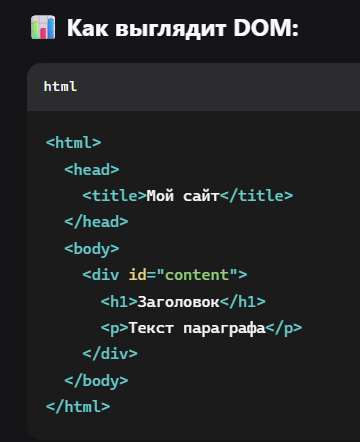

Блок try-except для обработки ошибок 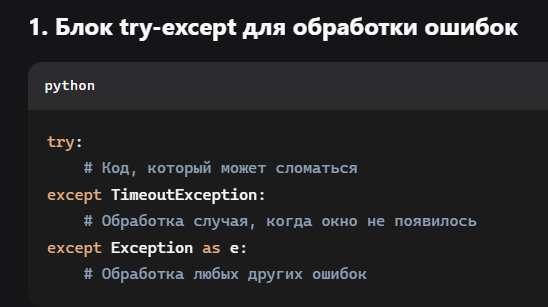

Shadow DOM (теневой DOM) — это технология, которая позволяет создавать изолированные деревья элементов внутри веб-страницы